<a href="https://colab.research.google.com/github/sihan827/2021_Winter_PE/blob/main/model_implementation/VGG11_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
\from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 데이터의 경로 설정

### 데이터 경로를 공유 폴더로 현재 설정되어 있음

### Cifar 10 데이터 사용


In [ ]:
# Setting Data Path
data_path = '/gdrive/My Drive/.data'

# 중요 Package Import Cell

### Package는 여기서 관리

In [ ]:
# Package Import Cell
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torch.nn as nn
import torch.nn.functional as F

# Util Code

In [ ]:
class AverageMeter(object):
    def __init__(self, name=''):
        self._name = name
        self.avg = 0.0
        self.sum = 0.0
        self.cnt = 0.0

    def reset(self):
        self.avg = 0.0
        self.sum = 0.0
        self.cnt = 0.0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

    def __str__(self):
        return "%s: %.5f" % (self._name, self.avg)

    def get_avg(self):
        return self.avg

    def __repr__(self):
        return self.__str__()

def accuracy(output, target, topk=(1,)):
    """ Computes the precision@k for the specified values of k """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    # one-hot case
    if target.ndimension() > 1:
        target = target.max(1)[1]

    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = torch.reshape(correct[:k], (-1,)).float().sum(0)
        res.append(correct_k.mul_(1.0 / batch_size))

    return res

# 데이터 로딩

In [ ]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

def get_loaders(train_portion, batch_size, path_to_save_data):
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])
    train_data = datasets.CIFAR10(root=path_to_save_data, train=True,
                                  download=True, transform=train_transform)

    num_train = len(train_data)  
    indices = np.arange(num_train)
    np.random.shuffle(indices)
    split = int(np.floor(train_portion * num_train))

    train_idx, valid_idx = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_idx)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)

    if train_portion == 1:
        return train_loader

    valid_sampler = SubsetRandomSampler(valid_idx)

    val_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2)

    return train_loader, val_loader


def get_test_loader(batch_size, path_to_save_data):
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    test_data = datasets.CIFAR10(root=path_to_save_data, train=False,
                                 download=True, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              shuffle=False, num_workers=16)
    return test_loader

# Input Data 훑어보기

In [ ]:
train_loader = get_test_loader(batch_size=8, path_to_save_data=data_path)
iterator = iter(train_loader)
images, labels = iterator.next()

Files already downloaded and verified


In [ ]:
classes = {
    0: 'plane', 
    1: 'car', 
    2: 'bird', 
    3: 'cat',
    4: 'deer', 
    5: 'dog', 
    6: 'frog', 
    7: 'horse', 
    8: 'ship', 
    9: 'truck'
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


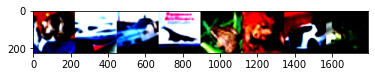

In [ ]:
img = utils.make_grid(images, padding=0)
img.shape
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
for idx in range(len(labels)):
  print(classes[labels[idx].item()])

cat
ship
ship
plane
frog
frog
car
frog


# Model 설계

In [ ]:
# VGGNet 중 논문에서의 형태 A
class VGG16_D(nn.Module):
    def __init__(self, classes=10):
        super(VGG16_D, self).__init__()
        self.classes = classes

        # 합성곱층 8개 + 최대풀링층 5개
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 완전연결층 3개 + 드롭아웃층 2개
        self.fc = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, self.classes)
        )

    def forward(self, x):       
        out = self.conv(x)
        out = out.view(-1, 25088)       
        out = self.fc(out)

        return out


# Training Design

In [ ]:
# Training Settings

train_valid_portion = 0.8
batch_size = 100
epoch = 20
learning_rate = 0.01

USE_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if USE_CUDA else 'cpu'

criterion = nn.CrossEntropyLoss()
model = VGG16_D().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)



In [ ]:
top1_meter = AverageMeter()
top5_meter = AverageMeter()
loss_meter = AverageMeter()

def test(loader):
    model.eval()
    with torch.no_grad():
        for step, (X, y) in enumerate(loader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            N = X.shape[0]

            outs = model(X)
            loss = criterion(outs, y)
            prec1, prec3 = accuracy(outs, y, topk=(1,5))
            top1_meter.update(prec1.item(), N)
            top5_meter.update(prec3.item(), N)
            loss_meter.update(loss.item(), N)

    top1_avg = top1_meter.get_avg()
    top5_avg = top5_meter.get_avg()
    loss_avg = loss_meter.get_avg()

    for avg in [top1_meter, top5_meter, loss_meter]:
        avg.reset()

    print('[Test] Loss: {loss:.4f}, Top1: {top1: .4f}, Top5: {top5: .4f}'.format(
        loss=loss_avg,
        top1=top1_avg,
        top5=top5_avg
    ))

def train():
    train_loader, valid_loader = get_loaders(train_valid_portion, batch_size, data_path)
    test_loader = get_test_loader(batch_size, data_path)

    

    for iter in range(epoch):
        model.train()

        for step, (X, y) in enumerate(train_loader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            N = X.shape[0]

            optimizer.zero_grad()
            outs = model(X)
            
            loss = criterion(outs, y)
            loss.backward()
            optimizer.step()

            prec1, prec3 = accuracy(outs, y, topk=(1,5))
            top1_meter.update(prec1.item(), N)
            top5_meter.update(prec3.item(), N)
            loss_meter.update(loss.item(), N)

            if step % 100 == 0:
                print('[%d %5d] loss : %f' % (iter, step, loss.item()))
        
        top1_avg = top1_meter.get_avg()
        top5_avg = top5_meter.get_avg()
        loss_avg = loss_meter.get_avg()

        for avg in [top1_meter, top5_meter, loss_meter]:
            avg.reset()

        print('Epoch[{cur_epoch}/{max_epoch}] [Train] Loss: {loss:.4f}, Top1: {top1: .4f}, Top5: {top5: .4f}'.format(
            cur_epoch=iter,
            max_epoch=epoch,
            loss=loss_avg,
            top1=top1_avg,
            top5=top5_avg
        ))

        test(valid_loader)

In [ ]:
train()

Files already downloaded and verified
Files already downloaded and verified
[0     0] loss : 2.301971
[0   100] loss : 2.303138
[0   200] loss : 2.302453
[0   300] loss : 2.299103
Epoch[0/20] [Train] Loss: 2.3029, Top1:  0.0980, Top5:  0.4961
[Test] Loss: 2.3023, Top1:  0.0978, Top5:  0.5078
[1     0] loss : 2.303144
[1   100] loss : 2.298457
[1   200] loss : 2.151384
[1   300] loss : 2.108296
Epoch[1/20] [Train] Loss: 2.1353, Top1:  0.1995, Top5:  0.6909
[Test] Loss: 1.9351, Top1:  0.2874, Top5:  0.8243
[2     0] loss : 1.971445
[2   100] loss : 1.817503
[2   200] loss : 1.683103
[2   300] loss : 1.752338
Epoch[2/20] [Train] Loss: 1.7465, Top1:  0.3542, Top5:  0.8690
[Test] Loss: 1.5727, Top1:  0.4306, Top5:  0.9076
[3     0] loss : 1.545711
[3   100] loss : 1.658950
[3   200] loss : 1.464646
[3   300] loss : 1.688144
Epoch[3/20] [Train] Loss: 1.5112, Top1:  0.4495, Top5:  0.9141
[Test] Loss: 1.3792, Top1:  0.5021, Top5:  0.9353
[4     0] loss : 1.455806
[4   100] loss : 1.556273
[4  